In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.4.1


In [72]:
# 08时数据
lv1_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_lv1_08.csv',index_col='Unnamed: 0')
Temperature_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_Temperature_08.csv',index_col='Unnamed: 0')
merge_dataset =pd.merge(lv1_08,Temperature_08,on=lv1_08.index)
merge_dataset = merge_dataset.set_index(['key_0'])
print(merge_dataset.shape)
merge_dataset.index = [i+':08' for i in merge_dataset.index]

# 20时数据
lv1_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_lv1_20.csv',index_col='Unnamed: 0')
Temperature_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_Temperature_20.csv',index_col='Unnamed: 0')
merge_dataset1 =pd.merge(lv1_08,Temperature_08,on=lv1_08.index)
merge_dataset1 = merge_dataset1.set_index(['key_0'])
print(merge_dataset1.shape)
merge_dataset1.index = [i+':20' for i in merge_dataset1.index]

# 连接
merge_dataset = merge_dataset.append(merge_dataset1)

# 将'Rain'列转换为离散数值
merge_dataset['Rain'] = pd.Categorical(merge_dataset['Rain'])
merge_dataset['Rain'] = merge_dataset.Rain.cat.codes

# 去除空数据
merge_dataset[merge_dataset<-1000] = np.nan
merge_dataset.dropna(inplace=True)

# 去除['10','Azim', 'Elev']几列
# 温度训练
merge_dataset.drop(['10','Rain', 'TkBB(K)','Rh(%)', 'Pres(mb)', 'Tir(K)', 'Azim', 'Elev',' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000'],axis=1,inplace=True)

# 保留小数位
merge_dataset = merge_dataset.round(1)

(365, 68)
(365, 68)


In [73]:
for i in merge_dataset.index:
    if(int(i[5:7])<5)or(int(i[5:7])>9):
        merge_dataset.drop(i,inplace=True)
del i

In [74]:
merge_dataset

,Tamb(K),51.250,52.280,53.850,54.940,56.660,57.290,58.800,0.00,0.10,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
2007/05/20:08,289.6,72.0,108.2,222.7,276.3,286.3,286.8,287.2,270.8,270.3,...,220.2,219.0,217.7,216.5,215.3,214.1,212.8,212.2,211.6,211.0
2007/05/24:08,279.1,68.6,104.2,217.9,269.2,276.7,277.3,277.4,267.0,266.5,...,221.4,220.0,218.6,217.2,215.8,214.3,212.9,211.6,210.5,209.4
2007/05/25:08,286.5,77.1,112.1,222.6,273.8,283.8,284.2,284.9,269.5,268.9,...,221.7,220.3,218.9,217.4,216.0,214.6,213.1,211.9,210.7,209.5
2007/05/28:08,287.8,71.1,107.2,221.3,274.4,284.1,284.8,285.2,269.6,269.1,...,221.4,220.1,218.9,217.7,216.4,215.1,213.9,212.5,211.1,209.7
2007/05/29:08,289.5,125.7,153.7,238.6,277.8,285.9,286.7,287.0,272.9,272.4,...,219.0,217.5,215.9,214.3,212.7,211.1,209.5,208.5,207.7,207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007/09/26:20,280.8,114.0,143.2,233.3,271.9,277.3,277.6,277.8,275.3,275.0,...,223.3,221.5,219.6,217.7,215.8,213.8,211.9,210.0,208.8,207.6
2007/09/27:20,279.3,116.7,145.4,233.3,270.9,275.9,276.4,276.7,272.7,272.4,...,222.7,220.9,219.0,217.1,215.3,213.4,211.4,209.7,208.8,207.8
2007/09/28:20,282.6,97.4,129.5,229.3,272.8,278.7,279.2,279.5,275.5,275.2,...,223.2,221.8,220.3,218.8,217.3,215.8,214.2,212.7,211.2,209.7
2007/09/29:20,283.1,117.7,147.0,236.2,274.7,280.2,280.4,280.9,276.7,276.3,...,221.7,219.9,218.1,216.3,214.5,212.7,210.8,209.1,208.0,207.0


In [75]:
# 归一化
def norm(x):
  return (x - merge_dataset.describe().transpose()['mean']) / merge_dataset.describe().transpose()['std']

merge_dataset.iloc[:,:8] = norm(merge_dataset).iloc[:,:8]

In [76]:
# 乱序，分离训练数据与测试数据
train_data = merge_dataset.sample(frac=0.8,random_state=0)
test_data = merge_dataset.drop(train_data.index)
# 分离标签
train_labels = train_data.iloc[:,8:]
test_labels = test_data.iloc[:,8:]
train_data.drop(train_labels.columns,axis=1,inplace=True)
test_data.drop(train_labels.columns,axis=1,inplace=True)

print(train_data.shape,test_data.shape,train_labels.shape,test_labels.shape)

(150, 8) (37, 8) (150, 47) (37, 47)


In [77]:
def build_model():
  model = keras.Sequential([
    layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(47, activation='relu'),
    layers.Dense(47)
  ])

  opt = tf.keras.optimizers.RMSprop(0.001)
  # tf.train.GradientDescentOptimizer(0.001)
  # tf.keras.optimizers.RMSprop(0.001)
  # tf.optimizers.Adam(1e-3)

  model.compile(loss='mse', #损失函数
                optimizer=opt, # 优化器
                metrics=['mae', 'mse'] # 性能评估指标
                )
  return model

In [78]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 47)                423       
_________________________________________________________________
dense_5 (Dense)              (None, 47)                2256      
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=1500, 
                    verbose=0,
                    validation_split = 0.2)

In [80]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1495,4.954015,1.714611,4.954015,9.170502,2.089000,9.170502,1495
1496,4.744519,1.670417,4.744519,6.847779,2.053502,6.847779,1496
1497,5.212354,1.771170,5.212354,7.517365,2.009307,7.517365,1497
1498,4.502861,1.620130,4.502861,7.208162,1.877709,7.208162,1498
1499,4.675512,1.646275,4.675512,6.911462,1.909014,6.911462,1499


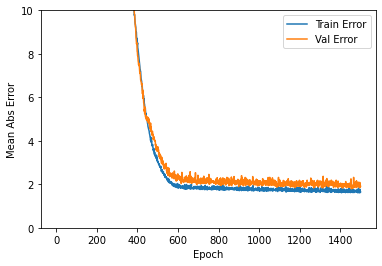

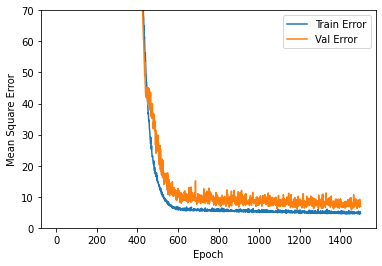

In [81]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,70])
  plt.legend()
  plt.show()


plot_history(history)

In [82]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("MAE: {:5.2f} ".format(mae))
print("MSE: {:5.2f} ".format(mse))
print("LOSS: {:5.2f} ".format(loss))

2/2 [==============================] - 0s 5ms/step - loss: 4.6721 - mae: 1.7012 - mse: 4.6721
MAE:  1.70 
MSE:  4.67 
LOSS:  4.67 


In [83]:
r1 = 0
for i in range(10):
    r = np.corrcoef(model.predict(test_data[i:i+1]), test_labels[i:i+1])
    r1 += r[0,1]
# print(r1/10)
print('相关系数 {:.4}'.format(r1/10))


相关系数 0.9968


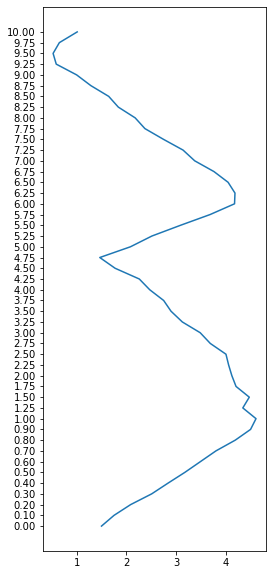

相关系数0.9988
2007/07/15:08    2.8388
dtype: float64


In [93]:
flag = 2
fig = plt.figure(figsize=(4,10))
Height = test_labels.columns
X1 = model.predict(test_data[flag:flag+1]).T
X2 = test_labels[flag:flag+1].T
plt.plot(np.abs(X1-X2),Height)
# plt.plot(X1,Height)
# plt.plot(X2,Height)
plt.show()
print('相关系数{:.4}'.format(np.corrcoef(X1.T,X2.T)[0,1]))
# print('平均偏差{:.4}'.format((X1-X2).mean().values))
# print(np.corrcoef(X1.T,X2.T))
print(np.abs(np.mean(X1-X2).round(4)))

